Functions
============

In geodynamics problems the material properties can change as a function of temperature (for example). Such relationships between objects are defined using ``functions`` in underworld. An example of such a relationship is where the viscosity is a function of temperature, both of which are be required by underworld to solve the system.

In some cases such relationships are further complicated in that material properties can be assigned to swarm particles, while the temperature data exists on finite element (FE) variables associated with the mesh. As swarm particles are free to move around the mesh, while FE variables are fixed on the mesh. In this case ``functions`` provide a way for information to be passed between swarms and FE variables.

In this notebook we will examine a few examples of using functions in underworld. This is a continuation of the swarm particle and FE variable notebooks, so there is a certain amount of assumed knowledge about swarms and FE variables.

**This notebook is broken down into the following examples:**

1. using functions to relate FE variables
2. some useful functions in built into underworld
3. revisit making shapes with swarm particles, this time using functions
4. using swarm particle indices to carry material information

**Keywords:** functions, swarms, FE variables, materials


In [1]:
%matplotlib inline
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np

Using functions to relate FE variables
----------

In this section we go through an example of using functions to setup relationships between FE variables, specifically making the viscosity and density of the fluid dependent on the temperature.

Set simulation parameters

In [2]:
dim = 2
boxHeight = 1.0
boxLength = 1.0
res = 64

Create a mesh and temperature field

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (boxLength, boxHeight))

temperatureMesh = elementMesh
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )

Set some initial conditions for the temperature

In [4]:
for index, coord in enumerate(temperatureMesh.data):
    temperatureField.data[index] = (1.0 - coord[1]*coord[1])

Plot the temperature field

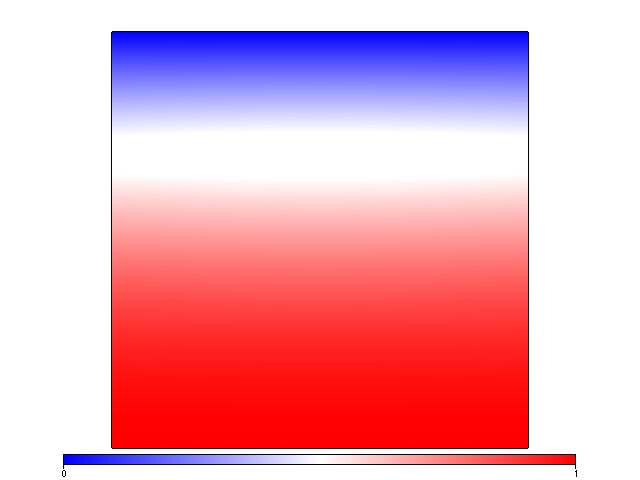

In [5]:
figtemp = plt.Figure()
figtemp.Surface( temperatureField, temperatureMesh, colours="blue white red" )
figtemp.show()

**Define a viscosity function**

Here we can use functions to construct a viscosity function that is true for all spatial coordinates as well as for all time. The underworld functions, denoted by ``fn``, allow us to write relationships intuitively without needing to re-write them each time a point needs to be evaluated.

The hard work of evaluating the function when it is needed is done by the underworld system solvers (see user guide **06_Systems.ipynb**).

Here we choose:

$$
    \eta = A \exp \left( - 10 T \right)
$$

where $A = 1$ and $T$ is the temperature field defined previously at each mesh point.

In [6]:
viscosityFn = fn.misc.constant(1.0) * fn.math.exp( -10.0 * temperatureField )

To demonstrate that this function works correctly when it is needed we will plot the viscosity function as a function of ``x`` and ``z``.

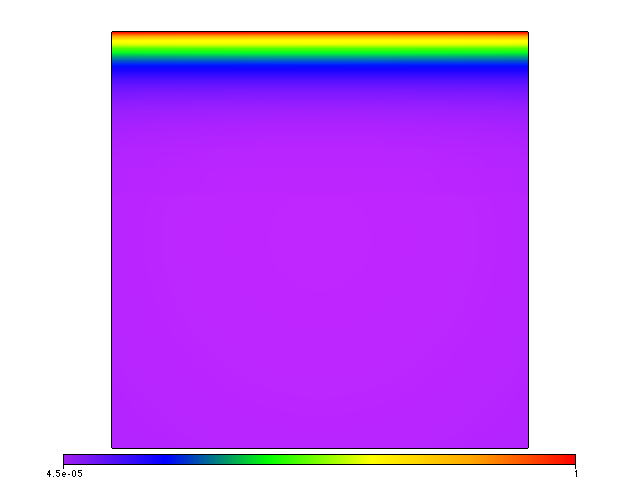

In [7]:
figEta = plt.Figure()
figEta.Surface( viscosityFn, temperatureMesh )
figEta.show()

**Define a density function**

Now we will define a simple density function to be
$$
    \rho = Ra T
$$
where $Ra$ is the Rayleigh number.

In [8]:
Ra = 1.0e6  # Rayleigh number

densityFn = Ra*temperatureField

Now plot the resulting density function.

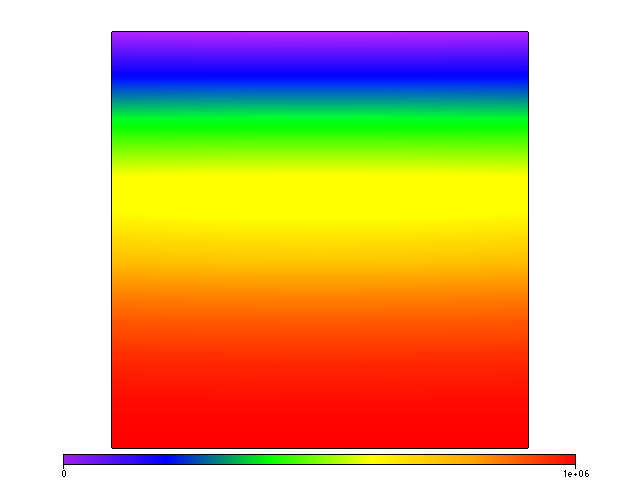

In [9]:
figRho = plt.Figure()
figRho.Surface( densityFn, temperatureMesh )
figRho.show()

Useful functions
-----

Underworld functions have many in-built methods for making new functions. For example the ``gradient`` function can be used to get the gradient (in each dimension) for any FE variable.

For example to examine the gradient of the temperature function, the following is used

In [10]:
gradTemp = temperatureField.gradientFn

Plot the result. Note that the output is linear while the temperature field was quadratic, as expected.

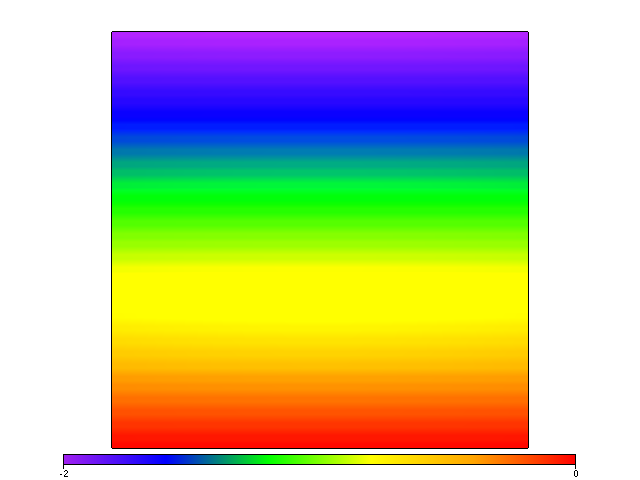

In [11]:
figGrad = plt.Figure()
figGrad.Surface( gradTemp[1], temperatureMesh )
figGrad.show()

Making shapes using conditional functions
-----

In this example we will make a few different shapes using a single particle swarm, but by changing the ``swarmVariable``. By using an additional variable for each particle any information can be carried by the particles, for example densities and viscosities. These can then be evaluated on the mesh points, allowing interaction between the swarms and the FE variables - i.e. allowing the temperature field to be coupled to viscosity.

For more information on how this method can be used to set material parameters to particles see the tutorial **1_05_StokesSinker.ipynb**.

**Create a higher resolution mesh**

In [12]:
res = 64
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                        elementRes  = (res, res), 
                                        minCoord    = (0., 0.), 
                                        maxCoord    = (1., 1.) )

**Create a swarm with random positions on the mesh**

In [13]:
# initialise a swarm. Note this must be the whole mesh, i.e. elementMesh.
swarm = uw.swarm.Swarm( feMesh=elementMesh )
# add a data variable which will store an index to determine material
swarmIndex = swarm.add_variable( dataType="int", count=1 )
# create a layout object that will populate the swarm across the whole domain
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
# activate the layout object
swarm.populate_using_layout( layout=swarmLayout )

**Define a shape: circle**

Want to have a definition of a circle based on the position of each swarm particle.

Firstly, create a function that returns true if the coordinates are inside a given function. To do this we define a python function that mathematically describes a shape, in this case a circle offset to the centre of the sinker. Note that this returns an underworld function, which can be used in the branching condition function below.




In [14]:
def circleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

Specify parameters for the circle

In [15]:
sphereRadius = 0.1
sphereCentre = (0.5, 0.5)

**Set index for each swarm particle**

Use the location of each particle to set the index depending on the position, stored in the 2 dimensional vector called ``coord``. In this case the circle function defined above will return ``True`` when the ``coord`` is within the shape and ``False`` otherwise. The branching conditional function will then set the ``swarmIndex`` data value for that particle to equal the ``1`` if it is inside the circle, or the ``0`` otherwise.

**Note:** ``fn.input()`` contains the swarm particle coordinates when the function is evaluated (e.g. in plotting or in the system solver).

In [16]:
# create a circle
coord = fn.input()
# set up the condition for being in a circle. if not in sphere then will return 0
conditions = [ ( circleFnGenerator( sphereCentre, sphereRadius) , 1), 
               ( True                                           , 0) ]
# use the branching conditional function to set each particle's index
swarmIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

**Branching conditional function**

The swarm index is set using a underworld function called 'branching.conditional' which has the form of:

    if( [ (condition function 1, action function 1), 
          (condition function 2, action function 2), 
          ... 
          (True                , final action function), 
          ] )

which begins at the first function and if it is true it preforms the first action, if it is not true then the next conditional function is tested and so on. If no condition functions return true then the function will return an error. To avoid this error the last condition function is set to true and the final action function serves the purpose of ``everything else``, for example a default background swarm index as in this case.

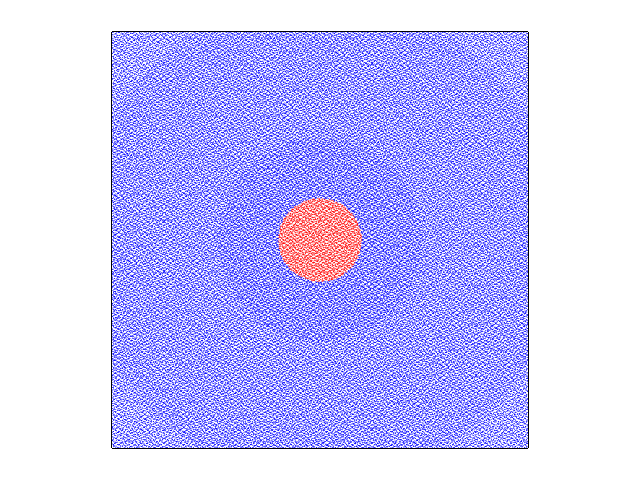

In [17]:
fig = plt.Figure()
fig.Points( swarm=swarm, colourVariable=swarmIndex, colours='blue red', colourBar = False, pointSize=2.0 )
fig.show()

**Define a shape: Box**

We use the same method as above to define a box and use this to set the particle swarm index.

In [18]:
def squareFnGenerator(centre = (0.0,0.0), width = 1.0):
    coord = fn.input()
    xDist = coord[0] - centre[0]
    zDist = coord[1] - centre[1]
    edgeDist = width*width/4.0
    xCond = (xDist*xDist) < edgeDist
    zCond = (zDist*zDist) < edgeDist
    cond =  (xCond & zCond)
    return cond

In [19]:
squareCentre = (0.5, 0.5)
squareWidth  = 0.1

In [20]:
# create a square
coord = fn.input()
# set up the condition for being in a circle. if not in sphere then will return 0
conditions = [ ( squareFnGenerator( squareCentre, squareWidth ) , 1 ), 
               ( True                                           , 0 ) ]
# use the branching conditional function to set each particle's index
swarmIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

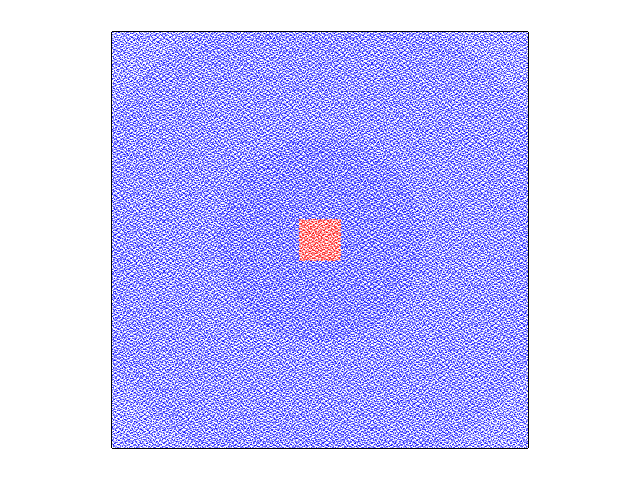

In [21]:
fig = plt.Figure()
fig.Points( swarm=swarm, colourVariable=swarmIndex, colours='blue red', colourBar = False, pointSize=2.0 )
fig.show()

Using swarm particle indices to carry material information
-------------

As a final example of branching functions and shapes we will set up a particle swarm to have a density inversion. This example is taken from the tutorial **1_06_Rayleigh_Taylor.ipynb**, which runs the initial conditions forward in time to see the instability develop.

Firstly we will create another variable associated with the particle swarm, called ``materialVariable`` which will store an index to determine the material type.

In [22]:
materialVariable = swarm.add_variable( dataType="int", count=1 )

Set a few index values to represent two different materials. This is done to make the code more readable.

In [23]:
denseIndex = 0
lightIndex = 1

Create a perturbation where the light material is at the bottom of the simulation is given index ``1`` and the denser surrounding material is given index ``0``.

In [24]:
wavelength = 2.0*boxLength
amplitude  = 0.02
offset     = 0.2
k = 2. * math.pi / wavelength

# load particle coordinates into coord
coord = fn.input()
# build shape up
perturbationFn = offset + amplitude*fn.math.cos( k*coord[0])
conditions = [ ( perturbationFn > coord[1] , lightIndex ),
               (                      True , denseIndex ) ]
# use the branching conditional function to set each particle's index
materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

Plot the swarm particles

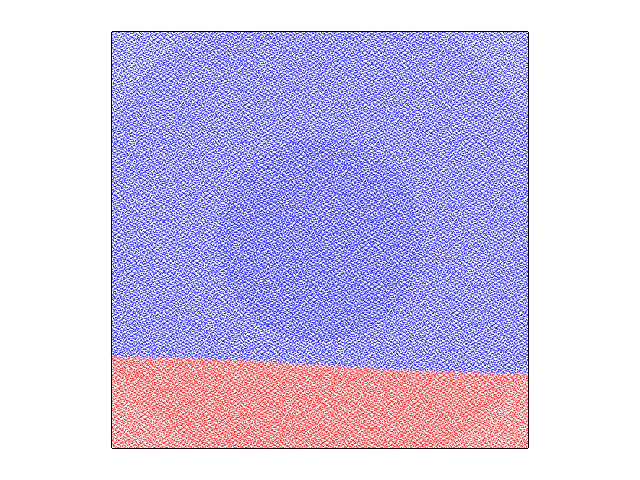

In [25]:
fig = plt.Figure()
fig.Points( swarm=swarm, colourVariable=materialVariable, colours='blue red', colourBar = False, pointSize=2.0 )
fig.show()